# Chapter 15 Processing Sequences Using RNNs and CNNs

## 本章の目的

教科書の記載

- RNNは任意の長さのシーケンスを処理できる
- 小規模なシーケンス: 全結合ネットワークでも処理可能
- 非常に長いシーケンス: CNNでも対応可能

この章ではRNNとCNNを使ったシーケンス処理を両方取り上げる。CNNアーキテクチャーはWaveNetを実装する。

最後にRNNの２つの課題について説明する

1. 不安定な購買
2. 非常に短い記憶

_This notebook contains all the sample code in chapter 15._

## Google Drive 接続 (Google Colabの場合のみ)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.


- まず、一般的なモジュールをいくつかインポートし、MatplotLib がインラインで図を描画することを確認し、図を保存する関数を用意しましょう。
- また、Python 3.5以降がインストールされていること（Python 2.xでも動作しますが、非推奨なのでPython 3の使用を強く推奨します）、Scikit-Learn ≥0.20 と TensorFlow ≥2.0 も確認しています。

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# 15.1 再帰ニューロンとレイヤ

教科書のキーワードまとめ

- 図はタイムステップ毎に同じ再帰ニューロンが描かれている。これを時系列に沿ってネットワークをアンロールすると表現する
    - ロールされている糸を引っ張りだして、長い糸にするような操作を**unrolling**と呼ぶ

![再帰ニューロン](https://docs.google.com/drawings/d/e/2PACX-1vTRiIniivsNo4KrjA2JmPBGBgmoPSnYG6nCMmKivXWDBwfnxUvbz5yjySB1cpv0KXu3ofG7-pG8fpda/pub?w=690&h=499)

$$
y_{(t)}=\phi\left({\mathbf W_x}^Tx_{(t)}+{\mathbf W_y}^Ty_{(t-1)}+\mathbf b\right)
$$

## 15.1.1 記憶セル

- 再帰ニューロンは一種の記憶をもっているといえる
    - y(t)はそれまでのタイムステップに対する入力の関数
- 何らかの状態を保持するニューラルネットワークの部分を記憶セル(Memory Cell)と言う

## 15.1.2 入出力シーケンス

- Sequence to Sequence Network: 株価のデータ, 時系列データから時系列データを出力
- Sequence to Vector Network: Twiterの投稿からポジティブかNegativeかを判定
- Vector to Sequence Network: 画像を入力として、文章を生成
- Encoder-Decoder Network: 翻訳


# 15.2 RNNの訓練

- RNNの訓練のポイントは時系列にアンロールしてから単純に通常のバックプロパゲーションを行うこと
- この方法をBPTT(Back Propagation Through Time) と言う


![BPTT](https://docs.google.com/drawings/d/e/2PACX-1vTmsmSV0_jntMRKnB8zztK68MHSveaBatnyBuuWDSk_fsmU5uUGMcSOpyGeDTor-7zDEddSaqzfAC1g/pub?w=889&h=395)

- アンロールされたネットワークを最初から最後まで通り抜ける前進パス(準伝搬のイメージ)
- 次にコスト関数(図中のC)を使って出力シーケンスを評価する
    - 一部の出力は無視する(図中Y(0), Y(1))
- コスト関数をアンロールされたネットワークの先頭に向けて後退しながら伝えて行く(逆伝搬)
- BPTTの仮定で計算した勾配を使ってパラメータを更新する
    - 勾配は、コスト関数が使ったすべての出力に伝えられる
    - 各タイムステップで同じWとBを使う


# 15.3 時系列データの予測

時系列 (Time Series) データは時間に対する変数の数に応じて以下の２つに分類される

- 単変量時系列(Univaiate Time Series)
    - タイムステップ毎のデータが一つだけ
    - 例: Webサイトの1時間毎のアクティブユーザ数
- 多変量時系列(Multivariate Time Series)
    - タイムステップ毎にデータが複数ある
    - 例: 会社の財務状況 (収益、負債, ...)

よく行われるタスクは以下の２つ

- 予測(Forcasting)
    - 需要予測など
- 帰属計算(imputation)
    - 欠損値を予測, 空白を埋めるタスク



## Generate the Dataset

In [3]:
def generate_time_series(batch_size, n_steps):
    """
    テスト用の時系列データを生成する

    Parameters
    ----------
    batch_size : int
        時系列データの数
    n_steps : int
        時系列データを長さn_step分ずつ出力する

    Returns
    -------
    series : numpy.ndarray
        (batch_size, n_steps, 1)のサイズの時系列データを生成する        
    """
    
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
#
# 少ないデータで中身をみるだけ
#
np.random.seed(42)
n_steps = 2
series = generate_time_series(4, n_steps + 1)
print(type(series))
print(series.shape)
print(series)

<class 'numpy.ndarray'>
(4, 3, 1)
[[[-0.5557167 ]
  [-0.6865542 ]
  [-0.49933645]]

 [[-0.2986145 ]
  [ 0.48002675]
  [-0.43288013]]

 [[-0.0655157 ]
  [ 0.5239564 ]
  [-0.6796143 ]]

 [[-0.178597  ]
  [-0.637436  ]
  [ 0.07153296]]]


In [5]:
#
# 教科書のパラメータに戻す
#
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
print(type(series))
print(series.shape)

<class 'numpy.ndarray'>
(10000, 51, 1)


In [6]:
# 訓練用: 最初から7000個までを利用, n_stepsの最後のデータを予測する
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]

# Validation用: 7001個目から9000個目まで利用
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]

# テスト用: 9001から10000個目までを利用
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [7]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    """
    作成した時系列データのグラフを生成する

    Parameters
    ----------
    series : numpy.ndarray
        時系列の入力データ
    y : numpy.ndarray
        予測したいデータ(ラベルデータ)
    y_pred : string
        予測されたデータ
    x_label : string
        グラフの横軸のラベル
    y_label : string
        グラフの縦軸のラベル
    legend  : boolean
        以下を表示されるためのフラグ
            - ラベル値: "Target"
            - 予測値: "Prediction"
    
    Returns
    -------
    無し
    """

    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

Saving figure time_series_plot


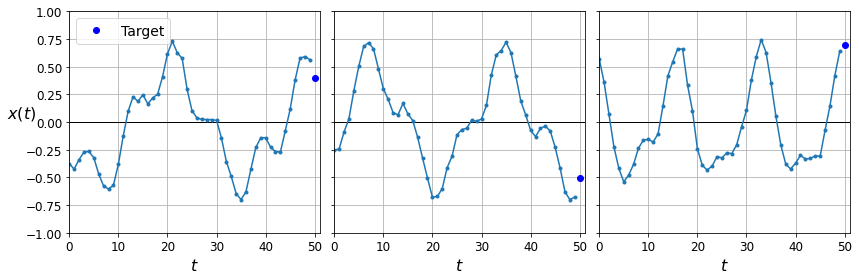

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0)) #この場合だと 一つ目のグラフだけに "Target" と表示される
save_fig("time_series_plot")
plt.show()

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions. In the book, I first used blue crosses for targets and red dots for predictions, then I reversed this later in the chapter. Sorry if this caused some confusion.

260 / 5,000
翻訳結果
**注**: このノートブックでは、青い点は目標を表し、赤い十字は予測を表します。 この本では、最初にターゲットに青い十字を使用し、予測に赤い点を使用しましたが、章の後半でこれを逆にしました. これにより混乱が生じた場合は申し訳ありません。

## 13.3.1 ベースライン指標 (Computing Some Baselines)

### 単純な予測 (Naive predictions)によるベースライン作成

- RNNでは、あらかじめベースライン指標を用意しておくことが多い
- もっとも単純な方法は個々の時系列データの最後の値の予測すること
- これを単純な予測(Native Predictions)と言う

精度をMSE (Mean Square Error)で求める

- y: 予測値
- Y: 正解値

$$
MSE=\sum_{i=1}^{n} (y_{i}-Y_i)^2
$$

In [10]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

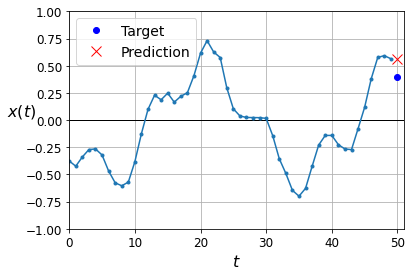

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 全結合ネットワークによる線形回帰モデル (Linear predictions) によるベースライン作成例

- 全結合ネットワークを利用
- 単純な線形回帰モデルを使い、個々の予測が時系列データ内の値の線形結合になるようにする

シーケンシャルAPIによる1層だけの線形回帰モデルを生成

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # [50, 1]の形状のndarrayを"flatten"にしているm, MNISTだと28x28
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

loss関数: MSE, Optimizer: AdamとしてNuralNetworkを生成する

重みが50個, バイアスが1個で51個の変数が生成

In [13]:
model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087150901556

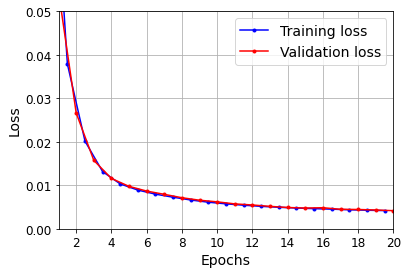

In [16]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


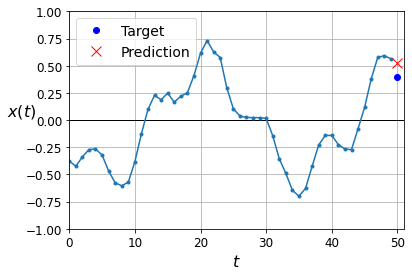

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

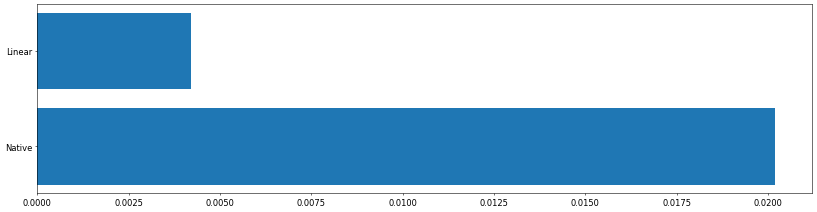

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5), dpi=50)
mse = [0.0202, 0.0042]  # 点数1
labels = ['Native', 'Linear']
plt.barh(labels, mse, align='center')

plt.show()

## 15.3.2 単純なRNNの実装 (Using a Simple RNN)

参考までに先程の線形回帰のコード, 比較のために再掲

```python
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
```

次にSequentialAPIでモデル作成する

- ニューロンが一つのモデルをここでは取り扱う
- RNNはどんな長さの時系列データも処理できるので、入力シーケンスの長さを指定する必要がない
    - そのため `input_shape=[None, 1]` と引数を与えている
- デフォルトではSimpleRNN層は双曲線正接活性化関数(tanh)を使う ([参考](https://nisshingeppo.com/ai/tanh-function/))
- 変数は以下の図を参考にするとWhx, Whh, b の3つとなる

![SimpleRNN](https://docs.google.com/drawings/d/e/2PACX-1vQ8Qovnq6rsuznWAQe7cyp6Vba3IADqyVuNLwx15MQo7IU9niNgnEA36kJT0NoUOTPtlbEsJ4F7gWmQ/pub?w=315&h=464)

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [20]:
# 先程と異なってadamの学習レートを調整している
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [21]:
fhistory = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0116 - val_loss: 0.0110

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

**単純な線形回帰モデルに勝てないことに注目**

小さいほど良い

- Native Prediction: `0.0202`
- 線形回帰モデル: `0.0042`
- SimpleRNN: `0.0109`

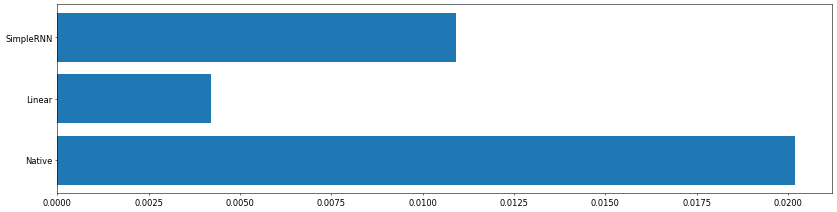

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5), dpi=50)
mse = [0.0202, 0.0042, 0.0109]  # 点数1
labels = ['Native', 'Linear', 'SimpleRNN']
plt.barh(labels, mse, align='center')

plt.show()

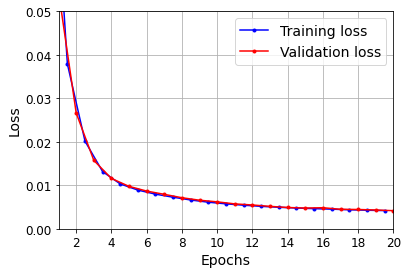

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 4ms/step


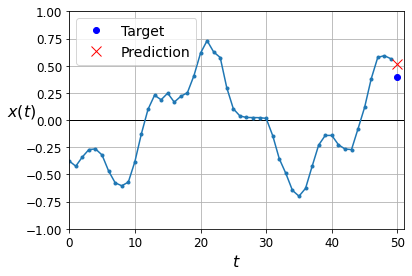

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.3 深層RNN (Deep RNNs)

教科書のコードに行く前に、分かりやすさを目的に寄り道してみる

- すべての再帰層で `return_sequences=True` を指定することを忘れないようにすること
- これを指定しないと、時間方向の情報が失われ最後のタイムステップの情報のみが出力される
    - 3次元配列から2次元配列となる

### 2層: (Layer1: 3units, Layer2: 1unit)

- L1: 15パラメータ
- L2: 5パラメータ

![2layers2](https://docs.google.com/drawings/d/e/2PACX-1vSgVoUvZAA1UEqShNevS01FSkNoIWfWeSndxuZp84ydXMfyydtW_H-klXNV43Bk9o5Z6rOXYLrtSr-H/pub?w=562&h=364)

1層目におけるパラメータの数の数え方

$$
\mathbf Y_{(t)}=\phi\left(\mathbf X^{(t)} \mathbf W_x+\mathbf Y^{(t-1)} \mathbf W_y +\mathbf b\right)
$$

$$
\mathbf X^{(t)} = \left( x^{t}\right)
$$

$$
\mathbf W^{(t)} = \left( w_{x11}^{t}, w_{x12}^{t}, w_{x13}^{t} \right)
$$

$$
\mathbf Y^{(t-1)} = \left( y_1^{t-1}, y_2^{t-1}, y_3^{t-1} \right)
$$


$$
\mathbf W_y  = \begin{bmatrix}w_{y11} & w_{y12} & w_{y13} \\ w_{y21} & w_{y22} & w_{y23} \\
w_{y31} & w_{y32} & w_{y33} \end{bmatrix}
$$

$$
\mathbf b = \left( b_1, b_2, b_3 \right)
$$

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(3, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(1)
])
model.compile(loss="mse", optimizer="adam")
model.summary()
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 3)           15        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1)                 5         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.5133 - val_loss: 0.1911
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.1040 - val_loss: 0.0795
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0624 - val_loss: 0.0530
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0424 - val_loss: 0.0353
Epoch 5/20
219/219 [==============================

0.005773584358394146

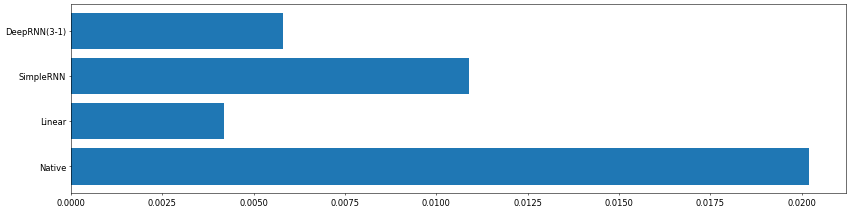

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5), dpi=50)
mse = [0.0202, 0.0042, 0.0109, 0.0058]  # 点数1
labels = ['Native', 'Linear', 'SimpleRNN', 'DeepRNN(3-1)']
plt.barh(labels, mse, align='center')

plt.show()

### 3層: (Layer1: 3units, Layer2: 3units, Layer3: 1unit)

![](https://docs.google.com/drawings/d/e/2PACX-1vQPAPIhLBHhWnigHoVUzmSCjhYnRbEAnHAU02FO_EFw1CyLgE36EpgnJ8JULtNrGguRM740yHuTS_Zk/pub?w=528&h=454)

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(3, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(3, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(loss="mse", optimizer="adam")
model.summary()
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 3)           15        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 3)           21        
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 1)                 5         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 8s 28ms/step - loss: 0.3511 - val_loss: 0.0689
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0504 - val_loss: 0.0434
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0417 - val_loss: 0.0411
Epoch 4/20
219/219 

0.004641686100512743

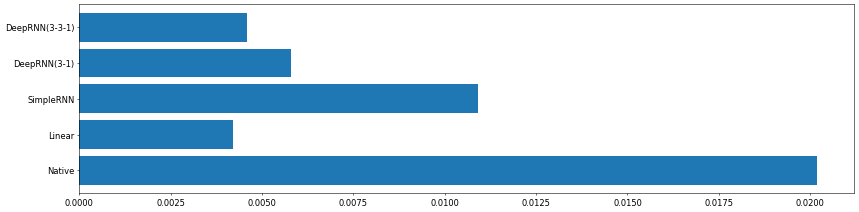

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5), dpi=50)
mse = [0.0202, 0.0042, 0.0109, 0.0058, 0.0046]  # 点数1
labels = ['Native', 'Linear', 'SimpleRNN', 'DeepRNN(3-1)', 'DeepRNN(3-3-1)']
plt.barh(labels, mse, align='center')

plt.show()

#### 3層: (Layer1: 20units, Layer2: 20units, Layer3: 1unit)

![3層20units](https://docs.google.com/drawings/d/e/2PACX-1vTvQbUmbIhsbmhv7twfBw0oBLWQNdEf4bkQYPcog1XRokd47m9NYFPIjNBrJun1dq0MYTHsYKZP1kFy/pub?w=512&h=424)

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(loss="mse", optimizer="adam")
model.summary()
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 9s 30ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
21

In [31]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0029


0.002910564886406064

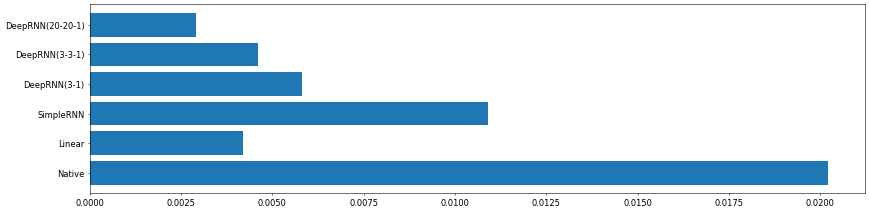

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5), dpi=50)
mse = [0.0202, 0.0042, 0.0109, 0.0058, 0.0046, 0.0029]  # 点数1
labels = ['Native', 'Linear', 'SimpleRNN', 
          'DeepRNN(3-1)', 'DeepRNN(3-3-1)', 'DeepRNN(20-20-1)']
plt.barh(labels, mse, align='center')

plt.show()

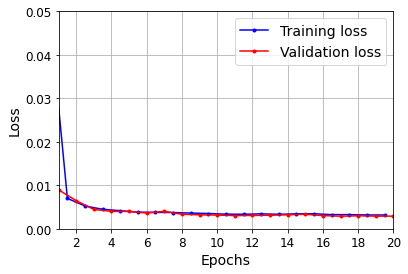

In [33]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 8ms/step


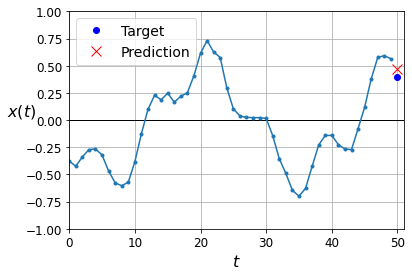

In [34]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 更に最終層を少し改善してみる...

Make the second `SimpleRNN` layer return only the last output:

**課題**

- RNNは必要な情報を次のタイムステップに伝えていくために、主として他の再帰層の隠れ状態を使うため最後の層の隠れ状態を使わない(最終層におけるRNNの計算コストが無駄)
- SimpleRNNだと活性化関数がtanhとなり -1から1の値に制限される

**Workaround**

- 最後の層を`Dense`に変更する。これによって以下を改善できる。
    - 早く収束し同等精度が得られる
    - 出力の活性化関数を変更できる



In [35]:
np.random.seed(42)
tf.random.set_seed(42)

# 変更前
#model = keras.models.Sequential([
#    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
#    keras.layers.SimpleRNN(20, return_sequences=True),
#    keras.layers.SimpleRNN(1)
#])

# 変更後
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.summary()
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
21

In [36]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.0026236248668283224

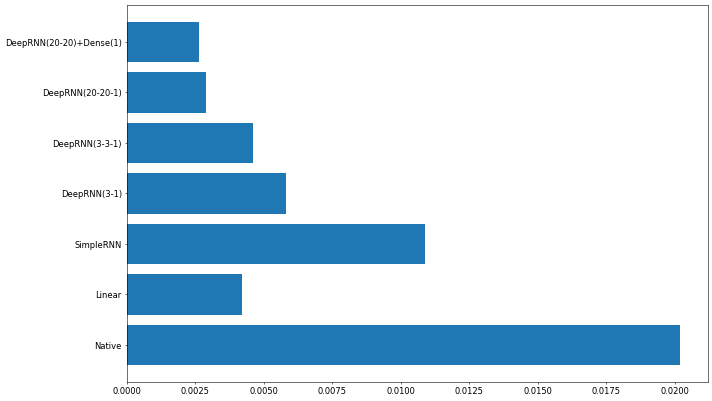

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.0202, 0.0042, 0.0109, 0.0058, 0.0046, 0.0029, 0.002623]  # 点数1
labels = ['Native', 'Linear', 'SimpleRNN', 
          'DeepRNN(3-1)', 'DeepRNN(3-3-1)', 'DeepRNN(20-20-1)', 'DeepRNN(20-20)+Dense(1)']
plt.barh(labels, mse, align='center')

plt.show()

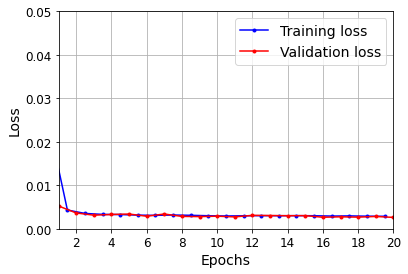

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 6ms/step


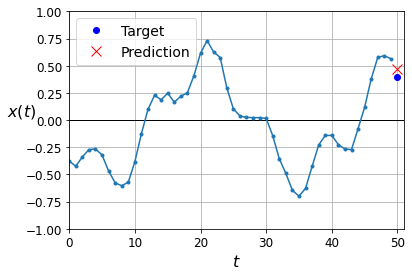

In [39]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.4 複数のタイムステップ後の予測 Forecasting Several Steps Ahead

- これまで: 次のタイムステップの値のみを予測
- やりたいこと: もっとさきまで、複数のタイムステップ先の予測を行う

やり方

- 例えば10ステップ後の予測を行いたければ、ターゲットを1ステップ後ではなく、10ステップ後に変更すればよい

### 学習済みモデルを使って一つずつ予測したものをつなげて10個先の未来を予測する

- 1個ずつ予測してつないで、それをつないでいく

![image.png](https://docs.google.com/drawings/d/e/2PACX-1vTpK8i6FHUbYEh4YZY3UfCnK_5mdZ8XGL9NavBwyn4m_EkM0V8Ub_MUEElOr8qXgb0lxv4UQVsF3BTW/pub?w=956&h=416)

In [40]:
np.random.seed(43) # not 42, as it would give the first series in the train set
print("n_steps:", n_steps)

# テストのため、60点ひとかたまりのタイムシリーズのテストデータを作成
series = generate_time_series(1, n_steps + 10)

# 入力とラベルに分ける
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

X = X_new
for step_ahead in range(10):
    #y_pred_one = model.predict(X[:, step_ahead:])
    #print("test", model.predict(X[:, step_ahead:]).shape)
    X_tmp = X[:, step_ahead:]
    y_pred_one = model.predict(X_tmp)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
    print("     X_tmp:", X_tmp.shape)
    print("y_pred_one:", y_pred_one.shape, y_pred_one)
    print("         X:", X.shape)

Y_pred = X[:, n_steps:]

n_steps: 50
1/1 [==============================] - 0s 25ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[0.5978653]]]
         X: (1, 51, 1)
1/1 [==============================] - 0s 25ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[0.62769616]]]
         X: (1, 52, 1)
1/1 [==============================] - 0s 20ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[0.5846197]]]
         X: (1, 53, 1)
1/1 [==============================] - 0s 21ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[0.44361186]]]
         X: (1, 54, 1)
1/1 [==============================] - 0s 23ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[0.2502621]]]
         X: (1, 55, 1)
1/1 [==============================] - 0s 23ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[-0.00020511]]]
         X: (1, 56, 1)
1/1 [==============================] - 0s 21ms/step
     X_tmp: (1, 50, 1)
y_pred_one: (1, 1, 1) [[[-0.22154343]]]
         X: (1, 57, 1)
1/1 [=========================

In [41]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


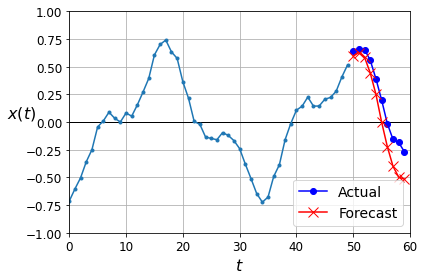

In [42]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

### ここからはまとめて10個予測してみる

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

このモデルを使用して、次の 10 個の値を予測してみましょう。最初に、さらに 9 つのタイム ステップでシーケンスを再生成する必要があります。

#### 学習用データセットの準備

In [43]:
np.random.seed(42)

n_steps = 50
# このNotebookの最初のデータセット`n_steps+1` と違って `n_steps + 10` となっている
series = generate_time_series(10000, n_steps + 10)

# 訓練用: 最初から7000個までを利用, n_stepsの最後のデータを予測する
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]

# Validation用: 7001個目から9000個目まで利用
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]

# テスト用: 9001から10000個目までを利用
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [44]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(7000, 50, 1)
(7000, 10)
(2000, 50, 1)
(2000, 10)
(1000, 50, 1)
(1000, 10)


#### 比較のために既存のモデルを使って、先程紹介したひとつづつ予測する場合のデータを作っておく

Now let's predict the next 10 values one by one:

In [45]:
X = X_valid
print(X.shape)
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

# 予測データ部分をスライス
Y_pred = X[:, n_steps:, 0]

(2000, 50, 1)
63/63 [==============================] - 0s 7ms/step


In [46]:
# 10steps分のデータが2000個ある
Y_pred.shape

(2000, 10)

In [47]:
# MSEで精度を評価
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510826

#### ベースライン (Native Prediction)


Let's compare this performance with some baselines: naive predictions and a simple linear model:

このパフォーマンスをいくつかのベースライン (単純な予測と単純な線形モデル) と比較してみましょう。

In [48]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

#### ベースライン (線形回帰)

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # 50stepsひとかたまりが入力データ.そのためinput_shapeを[50, 1]としている
    keras.layers.Flatten(input_shape=[50, 1]),
    # 10steps分の予測をするので10
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0222

In [50]:
print(X_valid.shape)
print(y_valid.shape)
model.evaluate(X_valid, Y_valid)

(2000, 50, 1)
(2000, 1)
63/63 [==============================] - 0s 2ms/step - loss: 0.0187


0.018695933744311333

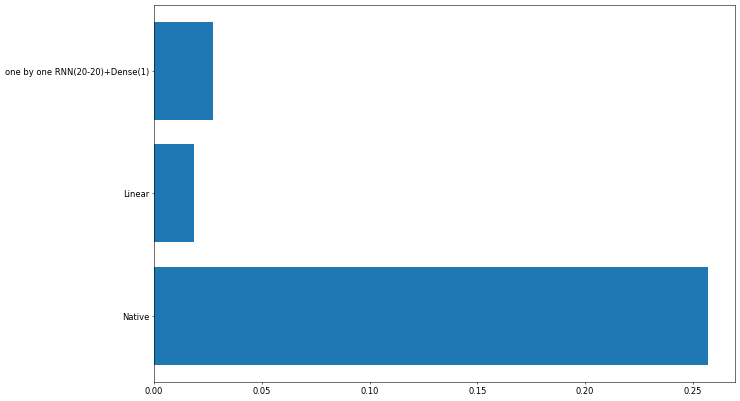

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.25697407, 0.018695933744311333, 0.027510826]  # 点数1
labels = ['Native', 'Linear', 'one by one RNN(20-20)+Dense(1)']
plt.barh(labels, mse, align='center')

plt.show()

#### Test1: 10Steps予測 (Sequence to Vector)

DeepRNNで10Stepsまとめて予測するモデルを作ってみる: Sequence to Vector

Now let's create an RNN that predicts all 10 next values at once:

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) # 最後はVectorとなって出力される
])

model.compile(loss="mse", optimizer="adam")
model.summary()
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
21

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0085


0.008532997220754623

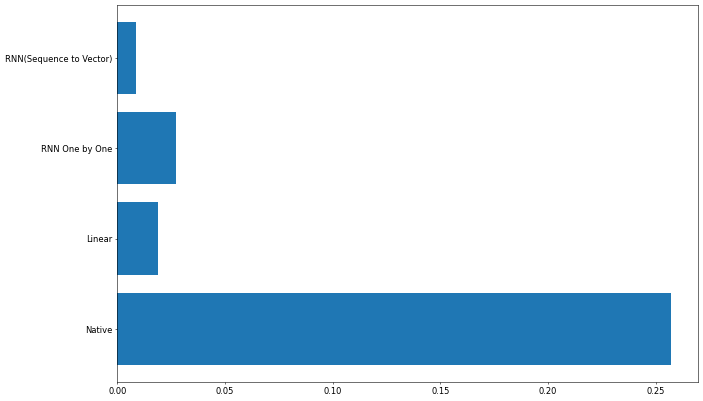

In [54]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.25697407, 0.018695933744311333, 0.027510826, 0.0085]  # 点数1
labels = ['Native', 'Linear', 'RNN One by One', 'RNN(Sequence to Vector)']
plt.barh(labels, mse, align='center')

plt.show()

#### Test1の効果確認

トレーニング時とは別のデータセットで効果を確認する

In [55]:
# 訓練時と変えるためシード値を42から43に変更
np.random.seed(43) 

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
print(model.predict(X_new).shape)

1/1 [==============================] - 0s 20ms/step
(1, 10)


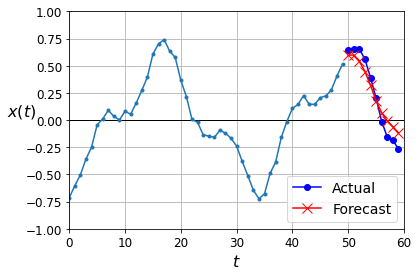

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Test2: 10Steps予測 (Sequence to Sequece)

10Stepsまとめて予測するモデルを作ってみる: Sequence to Sequece

https://github.com/keras-team/keras/issues/1029

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

それでは、各時間ステップで次の 10 ステップを予測する RNN を作成しましょう。 
つまり、タイムステップ 0 ～ 49 に基づいてタイムステップ 50 ～ 59 を予測するだけでなく

- タイム ステップ 0 でタイムステップ 1 ～ 10
- 次にタイム ステップ 1 でタイム ステップ 2 ～ 11

というように予測します。 最後のタイム ステップでタイム ステップ 50 ～ 59 を予測します。

モデルが因果関係にあることに注意してください。任意のタイム ステップで予測を行う場合、過去のタイム ステップしか見ることができません。

![StoS](https://docs.google.com/drawings/d/e/2PACX-1vSisl82q2jeOws-kZIELKCq1Hj9h84p8__2Umc-61TSImkkzcip4nCsOFzh1VklnbZPjjFqDRYVSTkQ/pub?w=950&h=445)

In [57]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [58]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

`keras.layers.TimeDistributed(keras.layers.Dense(10))` はこれがタイムシリーズであることを明確に示す役割もある

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    # ここが変更された
    # keras.layers.Dense(10) # 最後はVectorとなって出力される
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 最後のステップのみ評価するため、俺々関数を入れた
# 通常だと、全ステップでMSEが評価される
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

# オレオレ評価関数をmetricsで指定する
model.compile(loss="mse", 
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=[last_time_step_mse])
model.summary()
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0395 - las

In [60]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0192 - last_time_step_mse: 0.0082


[0.019169606268405914, 0.008176653645932674]

見やすさのためNative Predictionは除外して表示する.教科書では、MSEは0.006程度と書いているが、そこまで下がらない

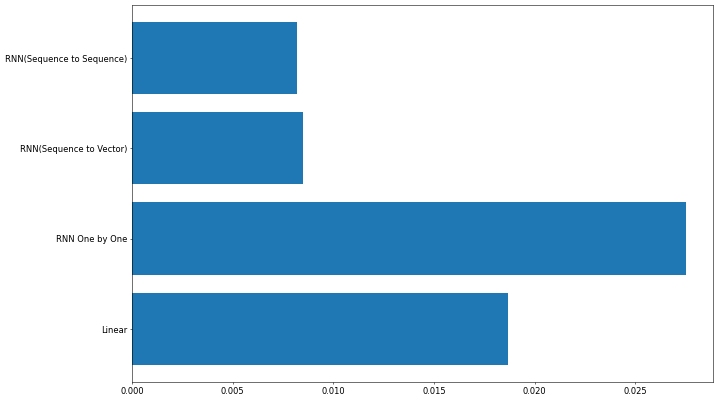

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.018695933744311333, 0.027510826, 0.0085, 0.0082]
labels = ['Linear', 'RNN One by One', 
          'RNN(Sequence to Vector)', 'RNN(Sequence to Sequence)']
plt.barh(labels, mse, align='center')

plt.show()

#### Test2の効果確認

トレーニング時とは別のデータセットで効果を確認する

In [62]:
# 確認用のデータセット作成
np.random.seed(43)
series = generate_time_series(1, 50 + 10)

# テストデータとラベルデータに分ける
X_new, Y_new = series[:, :50, :], series[:, 50:, :]

# X_newから予測データを作成する
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

# データの形状を一応確認
# Sequensial to Vectorの場合は (1, 10) と出力される
# (1, 50, 10)と出力されるが、50は上記図における緑色+赤色の棒線の数, 10は一つの棒線あたりの赤色の枠の数に相当
print(model.predict(X_new).shape)

1/1 [==============================] - 0s 22ms/step
(1, 50, 10)


- `keras.layers.TimeDistributed(keras.layers.Dense(10))` の効果を確認
- シーケンシャル, Vectorの場合、このデータを見ることができない

1/1 [==============================] - 0s 24ms/step


<function matplotlib.pyplot.show(*args, **kw)>

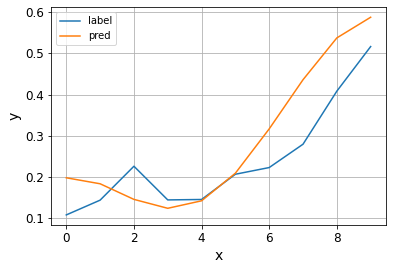

In [63]:
#model.predict(X_new)
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,9,10)

Y_init = model.predict(X_new)[:, -10][..., np.newaxis]

plt.plot(x, X_new[:, 40:50, :].reshape(10), label="label")
plt.plot(x, Y_init.reshape(10), label="pred")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show

1/1 [==============================] - 0s 20ms/step


<function matplotlib.pyplot.show(*args, **kw)>

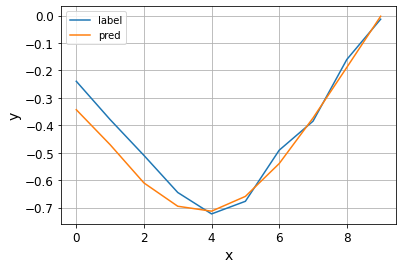

In [64]:
Y_init = model.predict(X_new)[:, -20][..., np.newaxis]

plt.plot(x, X_new[:, 30:40, :].reshape(10), label="label")
plt.plot(x, Y_init.reshape(10), label="pred")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show

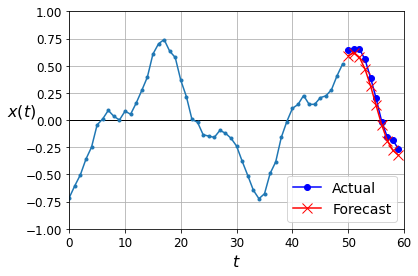

In [65]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 15.4 長いシーケンスの処理

長い時系列データをRNNで扱う場合、アンロールされたRNNは非常に深いネットワークになることから、以下の２つの問題に直面する

1. 不安定な勾配問題 (11章)
    - 11章記載の問題
        - 勾配消失/爆発問題
    - 問題による現象
        - 訓練の長時間化
        - 訓練結果が不安定
2. RNNは次第に最初の方の入力を忘れていく

15.4ではこの対応方法について学ぶ

## 15.4.1 不安定な勾配問題への対処

11章で学んだ以下の策はRNNでも利用可能

- オプティマイザの高速化
- ドロップアウト

しかし、例外としてReLUは役に立たないどころか、それどころか更に不安定にする可能性がある。

- 重みはすべてのタイプステップで共通のため出力爆発のリスクがある
    - 最初のタイムステップの出力をわずかに大きくするように重みが更新されると
        - 第2のタイムステップの出力増
        - 第3のタイムステップの出力増 ...
        - ....
        - その結果出力が爆発する
    - そのため-1から1で収まるtanhがデフォルトで使われる
- 出力でなく勾配が爆発したらTensorBoardで勾配の大きさをモニタリングする
    - 勾配クリッピングを使ったほうが良い

バッチ正則化はRNNでは効率よく使えない。実用上良い結果は得られない

- タイムステップ間で利用できず、再帰層間で使えるのみ
    - 頑張れば記憶セルにBN層を適用することはできるがCesar Laurentらが2015年の論文で示した理由により、良い結果は得られない


### Deep RNN with Batch Norm (うまく機能しないことを確認する)

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
model.summary()
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 batch_normalization (BatchN  (None, None, 20)         80        
 ormalization)                                                   
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, None, 20)          820       
                                                                 
 batch_normalization_1 (Batc  (None, None, 20)         80        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                      

In [67]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0288 - last_time_step_mse: 0.0164


[0.028785236179828644, 0.01639433205127716]

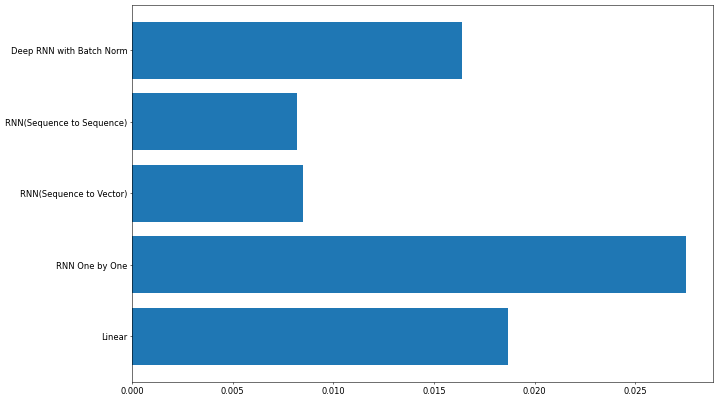

In [68]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.018695933744311333, 0.027510826, 0.0085, 0.0082, 0.0164]
labels = ['Linear', 'RNN One by One', 
          'RNN(Sequence to Vector)', 'RNN(Sequence to Sequence)', 'Deep RNN with Batch Norm']
plt.barh(labels, mse, align='center')

plt.show()

### Deep RNNs with Layer Norm (RNNにおけるBatch Normの課題を解決)

Batch Normと何が違うか？

- Batch Norm: バッチ次元で正規化
- Layer Norm: 特徴量次元で正規化
    - 個々のタイムステップで各インスタンスのために独立にその場で必要な統計量を計算できる
    - これは訓練中とテスト中で同じように振る舞う
    - 訓練セットのインスタンス全体で特徴量の統計を推計するために指数移動平均を使う必要もない

RNNでは、**Layer Norm** は入力と隠れ状態の線形結合の直後に行われる(活性化関数に通す前)。これを実現するためには、

- `keras.layers.RNN` 層をカスタマイズする
- 具体的には `keras.layers.Layer`を継承した俺々classを作成し、**カスタム記憶セル**と呼ばれる機能を定義する
- `keras.layers.RNN` 層の引数としてオレオレclassを指定する




In [69]:
from tensorflow.keras.layers import LayerNormalization

In [70]:
# keras.layers.Layerを継承していることに注意
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        # SimpleRNNCellがもつ2つの属性, 両者はともにunit数に等しい
        self.state_size = units
        self.output_size = units

        # 線形演算の後に、活性化関数の前に正則化を実行したいため、活性化関数なしでSimpleRNNCellで作ることに注意
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        # 上記で説明したように活性化関数の前に正則化層を作る
        self.layer_norm = LayerNormalization()

        # 活性化関数を設定
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    # call()メソッドが現在のタイムステップのinputsと前のタイムステップの隠れstatesの2個の引数をとることに注意
    # states1個以上のテンソルを含むリスト
    def call(self, inputs, states):
        # 単純なRNNセルを実行する。これは現在の入力と直前の隠れ状態を線形結合し結果を2回返す
        # new_states[0]はoutputsと等しい
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        # 正規化を実行し、活性化関数に通す
        norm_outputs = self.activation(self.layer_norm(outputs))
        # 通常の出力, 新しい隠れ状態の情報として2回返している
        return norm_outputs, [norm_outputs]

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # keras.layers.RNNの引数として、上記で作成したLNSinpleRNNCell()を利用する
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 44ms/step - loss: 0.1613 - last_time_step_mse: 0.1574 - val_loss: 0.0755 - val_last_time_step_mse: 0.0692
Epoch 2/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0665 - last_time_step_mse: 0.0575 - val_loss: 0.0597 - val_last_time_step_mse: 0.0484
Epoch 3/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0562 - last_time_step_mse: 0.0454 - val_loss: 0.0521 - val_last_time_step_mse: 0.0399
Epoch 4/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0498 - last_time_step_mse: 0.0378 - val_loss: 0.0466 - val_last_time_step_mse: 0.0337
Epoch 5/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0452 - last_time_step_mse: 0.0330 - val_loss: 0.0434 - val_last_time_step_mse: 0.0318
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0404 - last_time_step_mse: 0.0272 - val_loss: 0.0376 - val_last_time_step_mse: 0.0234
Epoch 7/20
219/2

In [72]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0262 - last_time_step_mse: 0.0137


[0.02618478424847126, 0.013716378249228]

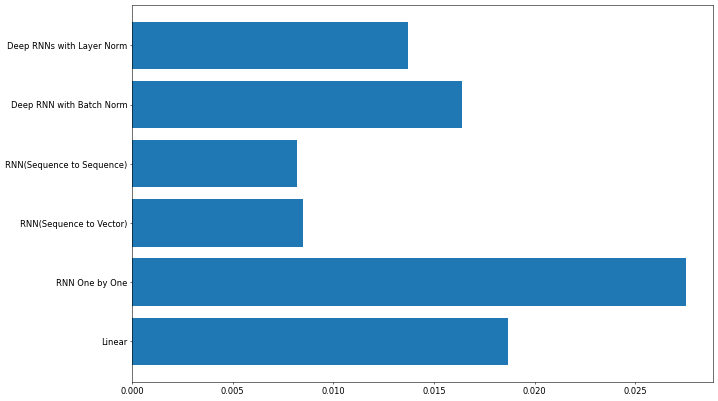

In [73]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.018695933744311333, 0.027510826, 0.0085, 0.0082, 0.0164, 0.0137]
labels = ['Linear', 'RNN One by One', 
          'RNN(Sequence to Vector)', 'RNN(Sequence to Sequence)', 'Deep RNN with Batch Norm', 'Deep RNNs with Layer Norm']
plt.barh(labels, mse, align='center')

plt.show()

### Creating a Custom RNN Class (これは何のため、教科書と連動していない？)

これまで見てきた以下のRNN層を使わず、オレオレRNNレイヤーを使うとき

- keras.layers.SimpleRNN
- keras.layers.RNN

In [74]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 46ms/step - loss: 0.1613 - last_time_step_mse: 0.1574 - val_loss: 0.0755 - val_last_time_step_mse: 0.0692
Epoch 2/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0665 - last_time_step_mse: 0.0575 - val_loss: 0.0597 - val_last_time_step_mse: 0.0484
Epoch 3/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0562 - last_time_step_mse: 0.0454 - val_loss: 0.0521 - val_last_time_step_mse: 0.0399
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0498 - last_time_step_mse: 0.0378 - val_loss: 0.0466 - val_last_time_step_mse: 0.0337
Epoch 5/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0452 - last_time_step_mse: 0.0330 - val_loss: 0.0434 - val_last_time_step_mse: 0.0318
Epoch 6/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0404 - last_time_step_mse: 0.0272 - val_loss: 0.0376 - val_last_time_step_mse: 0.0234
Epoch 7/20
219/2

In [76]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0262 - last_time_step_mse: 0.0137


[0.02618478424847126, 0.013716378249228]

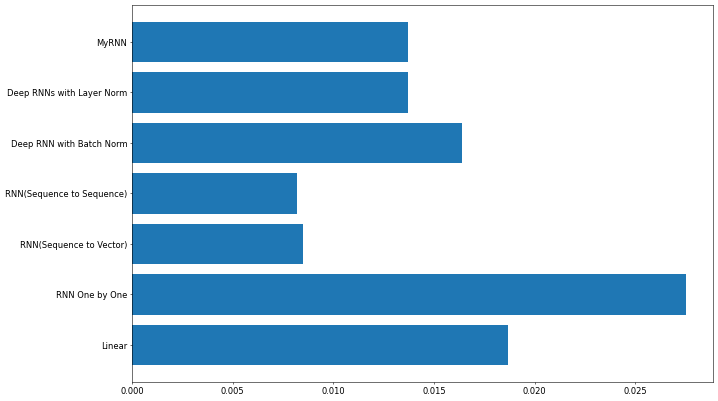

In [77]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10), dpi=50)
mse = [0.018695933744311333, 0.027510826, 0.0085, 0.0082, 0.0164, 0.0137, 0.0137]
labels = ['Linear', 'RNN One by One', 
          'RNN(Sequence to Vector)', 'RNN(Sequence to Sequence)', 'Deep RNN with Batch Norm', 'Deep RNNs with Layer Norm', 'MyRNN']
plt.barh(labels, mse, align='center')

plt.show()

# LSTMs

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 51ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 

In [79]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.008560795336961746]

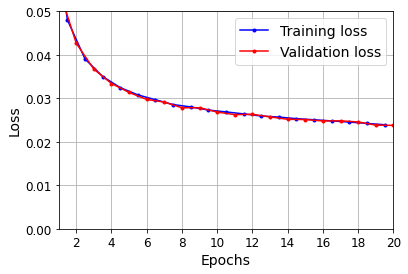

In [80]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [81]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 877ms/step


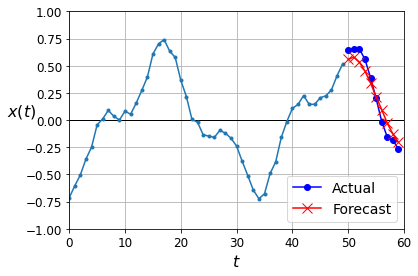

In [82]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 17s 55ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/2

In [84]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262810625135899]

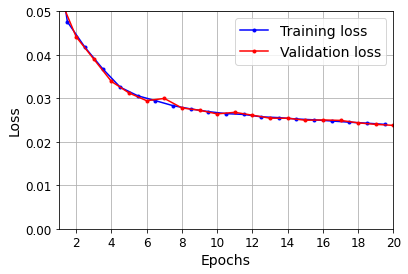

In [85]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [86]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 785ms/step


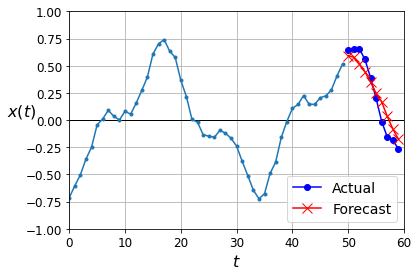

In [87]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 12s 36ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 19ms/step - loss: 0.0669 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0324 - last_time_step_mse: 0.0193 - val_loss: 0.0294 - val_last_time_step_mse: 0.0167
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0255 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0248 - last_time_step_mse: 0.0125 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0240 - last_time_step_mse: 0.0118 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [==

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [90]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [91]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [93]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 13s 51ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 11s 49ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

See Appendix A.

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [94]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 [==============================] - 23s 0us/step


In [95]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [96]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [97]:
eval_files

['/root/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [98]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [99]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [100]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [101]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [102]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [103]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [104]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.08627451  0.11764706  0.        ]
  [-0.01176471  0.16806725  0.        ]
  [ 0.02352941  0.07563025  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.06696428  0.        ]
  [-0.09019607 -0.07142857  0.        ]
  [-0.0862745  -0.04464286  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.00784314  0.11320752  0.        ]
  ...
  [ 0.11764708  0.01886791  0.        ]
  [-0.03529412  0.12264156  0.        ]
  [-0.19215688  0.33962262  1.        ]]

 ...

 [[-0.21276593 -0.01960784  0.        ]
  [-0.31382978  0.00784314  0.        ]
  [-0.37234044  0.13725491  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

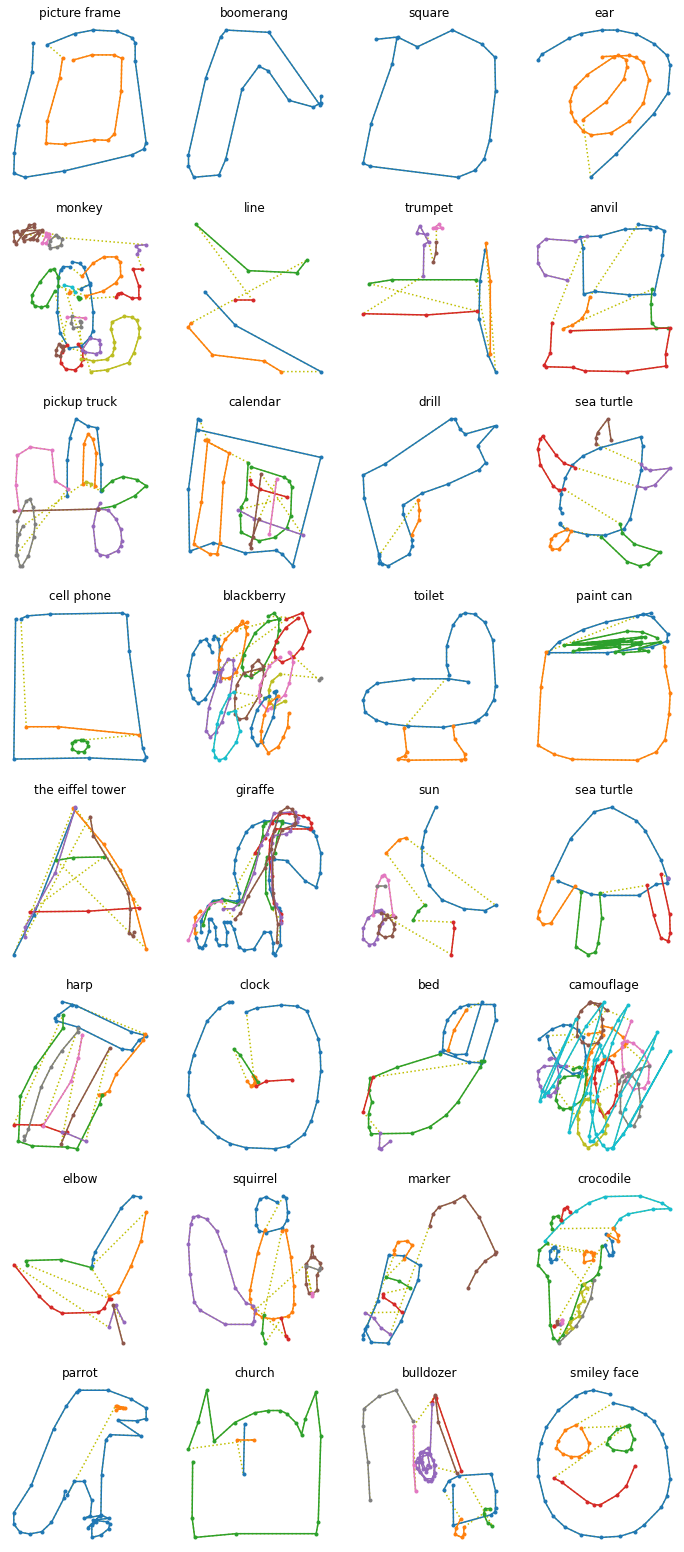

In [105]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

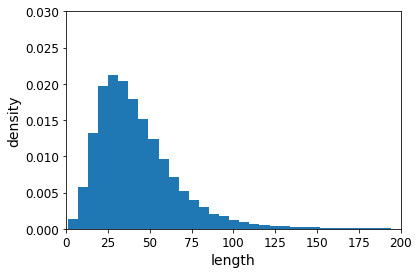

In [106]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [107]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
  10816/Unknown - 698s 64ms/step - loss: 5.6315 - accuracy: 0.0110 - sparse_top_k_categorical_accuracy: 0.0440

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")

## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Now we're ready to compile and train the model!

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

**Warning**: `model.predict_classes(X)` is deprecated. It is replaced with `np.argmax(model.predict(X), axis=-1)`.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")

# 参考

## np.newaxis

In [ ]:
a = np.arange(6).reshape(2, 3)
print(a)
print(a.shape)

In [ ]:
print(a[:, :, np.newaxis])

In [ ]:
print(a[:, :, np.newaxis].shape)

In [ ]:
b = np.arange(6).reshape(2, 3)
print(b)
print(b.shape)

In [ ]:
print(a[:, np.newaxis, :])
print(a[:, np.newaxis, :].shape)